In [0]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (104 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os, pickle, gc

In [0]:
#mount gdrive
from google.colab import drive

#check path to file
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Params to be changed**

In [0]:
root = 'gdrive/My Drive/adl_pro/'
slide_number = '110'
levels = [6,5,4,3,1]
deviation = 0

**No need to change anything below this.**

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

def plot_confusion_matrix(y_true, y_pred, classes,cmap=plt.cm.Blues):
    title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set( xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
            # ... and label them with the respective list entries
            xticklabels=classes, yticklabels=classes,
            title=title,
            ylabel='True label',
            xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", 
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def precision_recall(label, predictions, value):
    if value == 0:
      TP = len(predictions[predictions + label == 0])
      FP = len(predictions[predictions - label == -1])
      FN = len(predictions[predictions - label == 1])
    else:
      TP = len(predictions[predictions + label == 2])
      FP = len(predictions[predictions - label == 1])
      FN = len(predictions[predictions - label == -1])
      
    return 'Precision = ' + str( round(TP / ( TP + FP ),2) ) + ' Recall = ' + str( round(TP / ( TP + FN ),2) )
  
def auc(label, predictions):
  fpr, tpr, threshold = metrics.roc_curve(label, predictions)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

Analysing for level  6


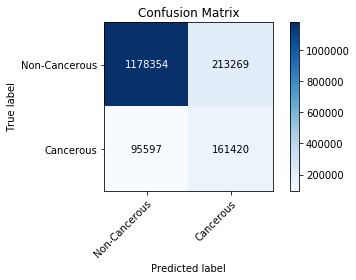

Non-Cancerous: 
	 Precision = 0.92 Recall = 0.85
Cancerous:
	 Precision = 0.43 Recall = 0.63


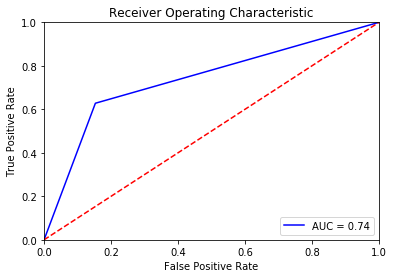


Analysing for level  5


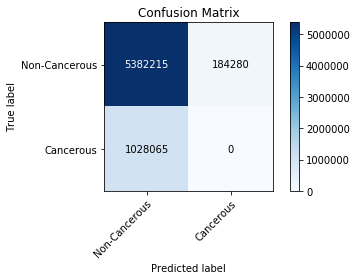

Non-Cancerous: 
	 Precision = 0.84 Recall = 0.97
Cancerous:
	 Precision = 0.0 Recall = 0.0


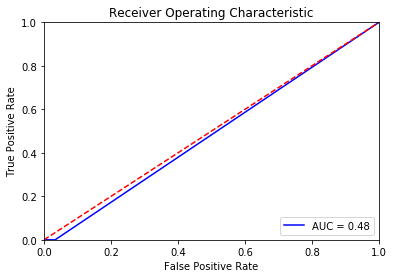


Analysing for level  4


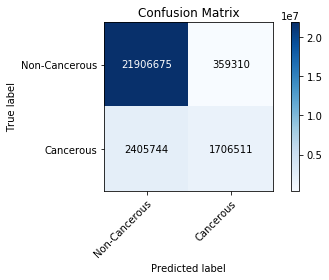

Non-Cancerous: 
	 Precision = 0.9 Recall = 0.98
Cancerous:
	 Precision = 0.83 Recall = 0.41


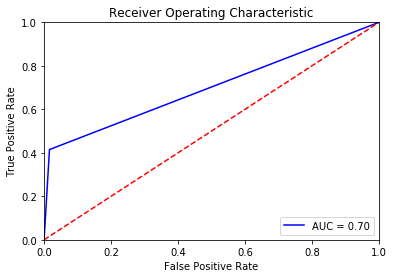


Analysing for level  3


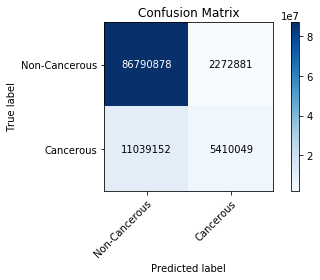

Non-Cancerous: 
	 Precision = 0.89 Recall = 0.97
Cancerous:
	 Precision = 0.7 Recall = 0.33


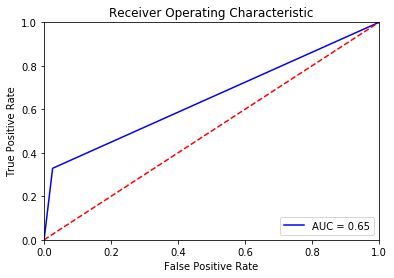

In [0]:
mask = open_slide(root + 'data/test/tumor_' + slide_number + '_mask.tif')

for level in levels:
  gc.collect()
  print('Analysing for level ', level)
  with open(root + 'data/test/tumor_' + slide_number + '_predicted_mask_level' + str(level) + '_final.pkl','rb') as f:
    data = pickle.load(f)
  
  x = 0
  y = 0

  width=mask.level_dimensions[level][0]
  height=mask.level_dimensions[level][1]

  mask_image = read_slide(mask, x, y, level, width, height)
  mask_image = mask_image[:,:,0].ravel()
  
  predictions = np.round( (data / np.max(data)) + deviation ).ravel()
  plot_confusion_matrix(mask_image,predictions,['Non-Cancerous','Cancerous'])
  plt.show()
  print('Non-Cancerous: \n\t', precision_recall(mask_image,predictions, 0))
  print('Cancerous:\n\t', precision_recall(mask_image,predictions, 1))
  auc(mask_image, predictions)
  print()

Analysing for Merged


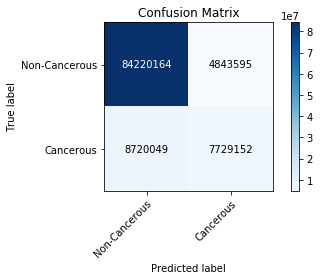

Non-Cancerous: 
	 Precision = 0.91 Recall = 0.95
Cancerous:
	 Precision = 0.61 Recall = 0.47


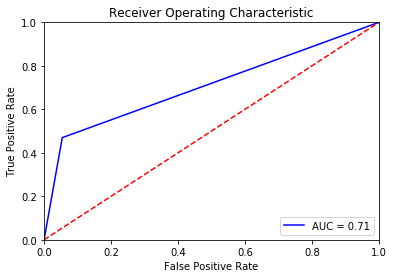

In [0]:
gc.collect()
print('Analysing for Merged')
with open(root + 'data/test/tumor_' + slide_number + '_predicted_mask_merged_final.pkl','rb') as f:
  data = pickle.load(f)

x = 0
y = 0
level = min(levels)
width=mask.level_dimensions[level][0]
height=mask.level_dimensions[level][1]

mask_image = read_slide(mask, x, y, level, width, height)
mask_image = mask_image[:,:,0].ravel()

predictions = np.round( (data / np.max(data)) + deviation ).ravel()
plot_confusion_matrix(mask_image,predictions,['Non-Cancerous','Cancerous'])
plt.show()
print('Non-Cancerous: \n\t', precision_recall(mask_image,predictions, 0))
print('Cancerous:\n\t', precision_recall(mask_image,predictions, 1))
auc(mask_image, predictions)
print()